In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from IWLS import IWLS, adaptive_IWLS, margin, first_order

# general parameters
n, k = 50, 5
job_n = 50

seed = 61
cov = 0.5

target = "probability"
np.random.seed(seed)

In [2]:
# generate data
mean_n = np.array([-1, 0])
mean_p = np.array([1, 0])
cov = np.eye(2) * cov
x_n = np.random.multivariate_normal(mean_n, cov, int(n/2))
x_p = np.random.multivariate_normal(mean_p, cov, int(n/2))

y_n = np.zeros(int(n/2)) # 0 labels
y_p = np.ones(int(n/2))  # 1 labels

X_train = np.vstack((x_n, x_p))
y_train = np.hstack((y_n, y_p))

# Choose mean_n or mean_p w.p. 1/2
if np.random.rand() < 0.5:
	x_test = np.random.multivariate_normal(mean_n, cov)
	y_test = 0
else:
	x_test = np.random.multivariate_normal(mean_p, cov)
	y_test = 1

logistic_classifier = LogisticRegression(penalty=None).fit(X_train, y_train)

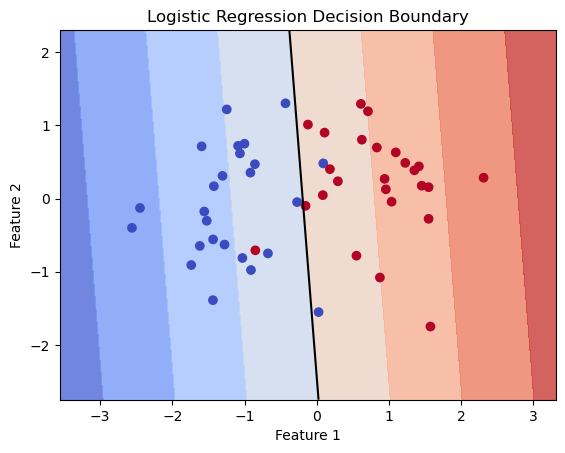

In [3]:
# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 100),
                    np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 100))
Z = logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.contour(xx, yy, Z, colors='black', linestyles='-', levels=[0])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

In [4]:
# Best Subset
best_k_subset = [0, 1, 2, 19, 35]

# IWLS
IWLS_best_k = IWLS(X_train, y_train, x_test)[:k]

# Adaptive IWLS
adaptive_IWLS_best_k = adaptive_IWLS(X_train, y_train, x_test, k=k, target=target)

# First-order method
FO_best_k = first_order(X_train, y_train, x_test, y_test)[:k]

# Margin-based approach
ind_n, ind_p = margin(X_train, y_train)
margin_n_best_k = ind_n[:k]
margin_p_best_k = ind_p[:k]

estimated_best_k_subset = {
    "IWLS": IWLS_best_k,
    "AIWLS": adaptive_IWLS_best_k,
    "FO": FO_best_k,
    "Margin": (margin_n_best_k, margin_p_best_k)
}

# Plot

In [5]:
def most_influential_subset_plot(logistic_classifier, x_test, k, best_k_subset, estimated_best_k_subset, method):
    # Plot the decision boundary of the original model and the reduced model, and mark the test point
    plt.figure()

    # Plot the decision boundary of the reduced model (solid line)
    # Train a Logistic Regression classifier on the reduced training set
    reduced_logistic_classifier = LogisticRegression(penalty=None)
    reduced_X_train = np.delete(X_train, best_k_subset, axis=0)
    reduced_y_train = np.delete(y_train, best_k_subset, axis=0)
    reduced_logistic_classifier.fit(reduced_X_train, reduced_y_train)
    reduced_Z = reduced_logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, reduced_Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.contour(xx, yy, reduced_Z, colors='black', linestyles='-', levels=[0])

    # Plot the decision boundary of the original model (dashed line)
    original_Z = logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

    # Mark the dataset points with a marker ('o' symbol)
    plt.scatter(reduced_X_train[:, 0], reduced_X_train[:, 1], c=reduced_y_train, cmap=plt.cm.coolwarm, marker='o')

    # Mark the test point with a marker ('s' symbol)
    plt.scatter(x_test[0], x_test[1], c='#12afc2', marker='s', s=20, label="Test Point")
    
    # Mark the best subset of removed data points with a different marker ('o' symbol)
    best_subset_points = np.take(X_train, best_k_subset, axis=0).reshape(-1, 2)
    plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='#ae4cee', marker='o', label="Best Subset")

    # Mark the estimated best subset of removed data points with a different marker ('x' symbol)
    if method == "IWLS":
        IWLS_best_k_points = np.take(X_train, estimated_best_k_subset, axis=0).reshape(-1, 2)
        plt.scatter(IWLS_best_k_points[:, 0], IWLS_best_k_points[:, 1], c='#f17fff', marker='x', s=70, label="IWLS")
    elif method == "AIWLS":
        adaptive_IWLS_best_k_points = np.take(X_train, estimated_best_k_subset, axis=0).reshape(-1, 2)
        plt.scatter(adaptive_IWLS_best_k_points[:, 0], adaptive_IWLS_best_k_points[:, 1], c='#f17fff', marker='x', s=70, label="Adaptive IWLS")
    elif method == "FO":
        FO_best_k_points = np.take(X_train, estimated_best_k_subset, axis=0).reshape(-1, 2)
        plt.scatter(FO_best_k_points[:, 0], FO_best_k_points[:, 1], c='#f17fff', marker='x', s=70, label="First-Order")
    elif method == "Margin":
        margin_n_best_k = estimated_best_k_subset[0]
        margin_p_best_k = estimated_best_k_subset[1]
        margin_n_best_k_points = np.take(X_train, margin_n_best_k, axis=0).reshape(-1, 2)
        plt.scatter(margin_n_best_k_points[:, 0], margin_n_best_k_points[:, 1], c='#502a55', marker='x', s=70, label="Margin (N)")

        # Mark the margin (P) best subset of removed data points with a different marker ('x' symbol)
        margin_p_best_k_points = np.take(X_train, margin_p_best_k, axis=0).reshape(-1, 2)
        plt.scatter(margin_p_best_k_points[:, 0], margin_p_best_k_points[:, 1], c='#f17fff', marker='x', s=70, label="Margin (P)")

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundary with Removal Size {k}')
    plt.legend()
    plt.show()

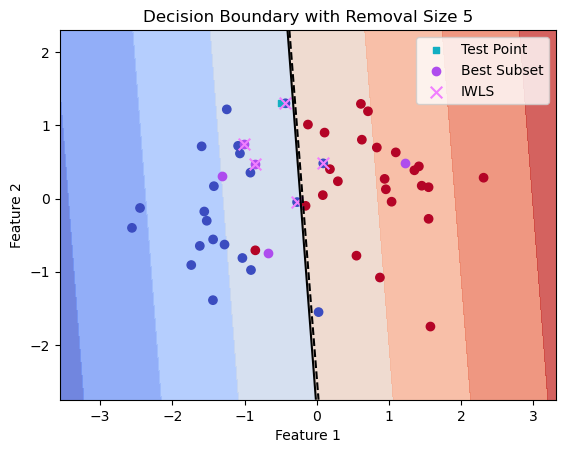

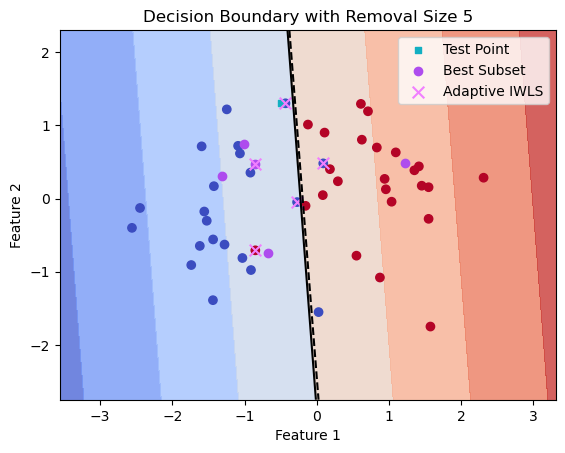

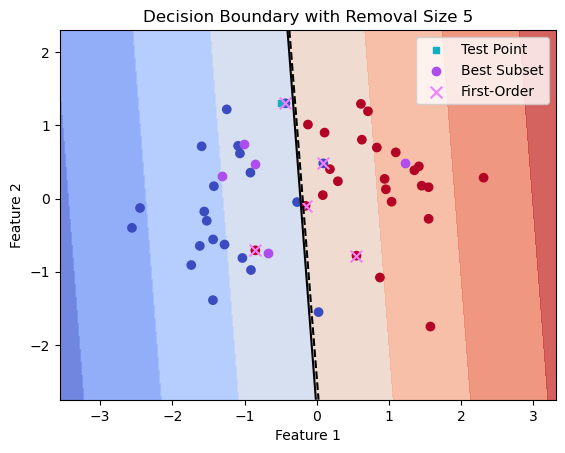

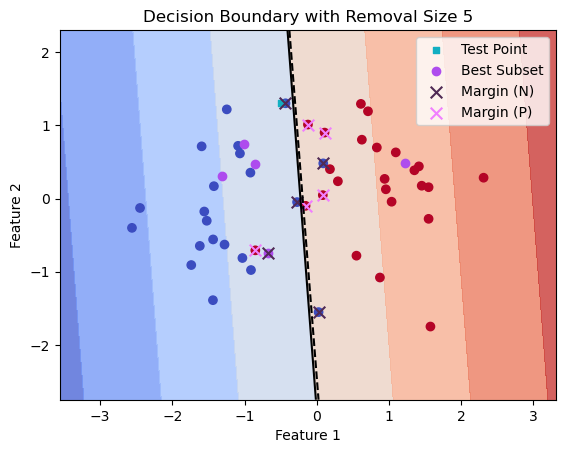

In [6]:
for method in ["IWLS", "AIWLS", "FO", "Margin"]:
    most_influential_subset_plot(logistic_classifier, x_test, k, best_k_subset, estimated_best_k_subset[method], method=method)